# Ablation 2.3: Quality Validation Analysis

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import glob
import re
from collections import defaultdict

sns.set_theme(style="whitegrid")

fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

plt.rcParams.update({
    "font.size": 27,
    "axes.titlesize": 27,
    "axes.labelsize": 27,
    "xtick.labelsize": 22,
    "ytick.labelsize": 18,
    "legend.fontsize": 22,
    "figure.titlesize": 27
})

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
RESULTS_DIR = './results'
benchmark_files = defaultdict(list)
result_files = glob.glob(f"{RESULTS_DIR}/*_run_*_results.json")
legend_names = {
    'ffhq': 'FFHQ',
    'adience': 'Adience',
    'animals': 'Animals',
    'fruits': 'Fruits',
}
for result_file in result_files:
    filename = result_file.split('/')[-1]
    match = re.match(r'([^_]+(?:_[^_]+)*)_run_\d+_results\.json', filename)
    if match:
        benchmark_name = match.group(1)
        benchmark_files[benchmark_name].append(result_file)

all_summary_data = []
for benchmark_name, files in benchmark_files.items():
    for result_file in files:
        try:
            with open(result_file, 'r') as f:
                data = json.load(f)
                if 'with_quality_filter' in data and 'without_quality_filter' in data:
                    for scenario_key, scenario_name in [('with_quality_filter', 'With Quality Filter'),
                                                       ('without_quality_filter', 'Without Quality Filter')]:
                        scenario_results = data.get(scenario_key, { })
                        all_summary_data.append({
                            'benchmark': legend_names.get(benchmark_name, benchmark_name),
                            'scenario': scenario_name,
                            'initial_worst_accuracy': data.get('initial_worst_group_accuracy', 0),
                            'final_worst_accuracy': scenario_results.get('final_worst_group_accuracy', 0)
                        })
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing {result_file}: {e}")
            continue

df_summary = pd.DataFrame(all_summary_data)
df_summary['improvement'] = df_summary['final_worst_accuracy'] - df_summary['initial_worst_accuracy']

/tmp/ipykernel_3093080/592375881.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_3093080/592375881.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_3093080/592375881.py:22: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


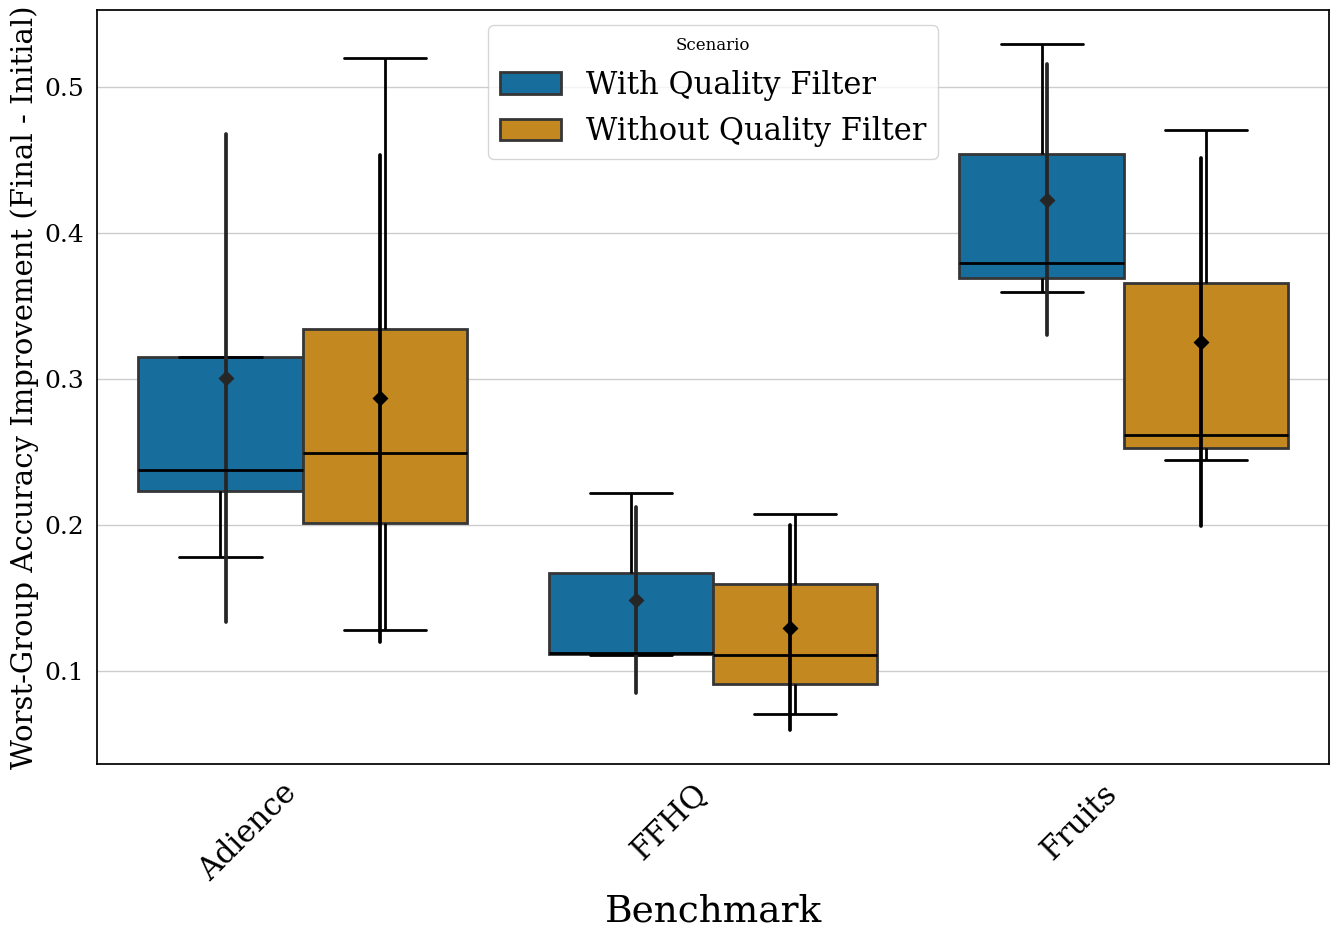

In [3]:
plt.figure(figsize=(14, 10))
ax = sns.boxplot(
    data=df_summary,
    x='benchmark',
    y='improvement',
    hue='scenario',
    palette='colorblind',
    showfliers=False,
    linewidth=2
)

# Add median (horizontal) lines like candlestick style
for i, artist in enumerate(ax.artists):
    # Each box artist
    artist.set_edgecolor('black')
    artist.set_linewidth(2)
for line in ax.lines:
    line.set_linewidth(2)
    line.set_color('black')

# Add "point" for mean, styled
sns.pointplot(
    data=df_summary,
    x='benchmark',
    y='improvement',
    hue='scenario',
    dodge=0.375,
    ax=ax,
    join=False,
    marker="D",
    color='black',
    markersize=6,
    legend=False,
    ci='sd'
)

ax.set_xlabel('Benchmark')
ax.set_ylabel('Worst-Group Accuracy Improvement (Final - Initial)', fontsize=21)
plt.xticks(rotation=45, ha='right')

# Remove duplicate legend from pointplot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Scenario')

plt.tight_layout()
plt.savefig(fig_dir / 'accuracy_improvement_comparison_candlestick.png', bbox_inches='tight', dpi=300)
plt.show()